In [ ]:
import numpy  as np
import random
import os

# Function: Initialize Variables
def initial_population(colony_size, min_values, max_values, target_function):
    population = np.zeros((colony_size, len(min_values) + 1))
    for i in range(0, colony_size):
        for j in range(0, len(min_values)):
             population[i,j] = random.uniform(min_values[j], max_values[j]) 
        population[i,-1] = target_function(population[i,0:population.shape[1]-1])
    return population

############################################################################

# Function: Fitness
def fitness_function(population): 
    fitness = np.zeros((population.shape[0], 2))
    for i in range(0, fitness.shape[0]):
        fitness[i,0] = 1/(1+ population[i,-1] + abs(population[:,-1].min()))
    fit_sum = fitness[:,0].sum()
    fitness[0,1] = fitness[0,0]
    for i in range(1, fitness.shape[0]):
        fitness[i,1] = (fitness[i,0] + fitness[i-1,1])
    for i in range(0, fitness.shape[0]):
        fitness[i,1] = fitness[i,1]/fit_sum
    return fitness

# Function: Selection
def roulette_wheel(fitness): 
    ix = 0
    random = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
    for i in range(0, fitness.shape[0]):
        if (random <= fitness[i, 1]):
          ix = i
          break
    return ix

############################################################################

# Function: Random Walk
def random_walk(iterations):
    x_random_walk = [0]*(iterations + 1)
    x_random_walk[0] = 0
    for k in range(1, len( x_random_walk)):
        rand = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        if rand > 0.5:
            rand = 1
        else:
            rand = 0
        x_random_walk[k] = x_random_walk[k-1] + (2*rand - 1)       
    return x_random_walk

# Function: Combine Ants
def combine(population, antlions):
    combination = np.vstack([population, antlions])
    combination = combination[combination[:,-1].argsort()]
    for i in range(0, population.shape[0]):
        for j in range(0, population.shape[1]):
            antlions[i,j]   = combination[i,j]
            population[i,j] = combination[i + population.shape[0],j]
    return population, antlions

# Function: Update Antlion
def update_ants(population, antlions, count, iterations, min_values, max_values, target_function):
    i_ratio       = 1
    minimum_c_i   = np.zeros((1, population.shape[1]))
    maximum_d_i   = np.zeros((1, population.shape[1]))
    minimum_c_e   = np.zeros((1, population.shape[1]))
    maximum_d_e   = np.zeros((1, population.shape[1]))
    elite_antlion = np.zeros((1, population.shape[1]))
    if  (count > 0.10*iterations):
        w_exploration = 2
        i_ratio = (10**w_exploration)*(count/iterations)  
    elif(count > 0.50*iterations):
        w_exploration = 3
        i_ratio = (10**w_exploration)*(count/iterations)   
    elif(count > 0.75*iterations):
        w_exploration = 4
        i_ratio = (10**w_exploration)*(count/iterations)    
    elif(count > 0.90*iterations):
        w_exploration = 5
        i_ratio = (10**w_exploration)*(count/iterations)   
    elif(count > 0.95*iterations):
        w_exploration = 6
        i_ratio = (10**w_exploration)*(count/iterations)
    for i in range (0, population.shape[0]):
        fitness = fitness_function(antlions)
        ant_lion = roulette_wheel(fitness)
        for j in range (0, population.shape[1] - 1):   
            minimum_c_i[0,j]   = antlions[antlions[:,-1].argsort()][0,j]/i_ratio
            maximum_d_i[0,j]   = antlions[antlions[:,-1].argsort()][-1,j]/i_ratio
            elite_antlion[0,j] = antlions[antlions[:,-1].argsort()][0,j]
            minimum_c_e[0,j]   = antlions[antlions[:,-1].argsort()][0,j]/i_ratio
            maximum_d_e[0,j]   = antlions[antlions[:,-1].argsort()][-1,j]/i_ratio  
            rand = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
            if (rand < 0.5):
                minimum_c_i[0,j] =   minimum_c_i[0,j] + antlions[ant_lion,j]
                minimum_c_e[0,j] =   minimum_c_e[0,j] + elite_antlion[0,j]
            else:
                minimum_c_i[0,j] = - minimum_c_i[0,j] + antlions[ant_lion,j]
                minimum_c_e[0,j] = - minimum_c_e[0,j] + elite_antlion[0,j]
                
            rand = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
            if (rand >= 0.5):
                maximum_d_i[0,j] =   maximum_d_i[0,j] + antlions[ant_lion,j]
                maximum_d_e[0,j] =   maximum_d_e[0,j] + elite_antlion[0,j]
            else:
                maximum_d_i[0,j] = - maximum_d_i[0,j] + antlions[ant_lion,j]
                maximum_d_e[0,j] = - maximum_d_e[0,j] + elite_antlion[0,j]   
            x_random_walk = random_walk(iterations)
            e_random_walk = random_walk(iterations)    
            min_x, max_x = min(x_random_walk), max(x_random_walk)
            x_random_walk[count] = (((x_random_walk[count] - min_x)*(maximum_d_i[0,j] - minimum_c_i[0,j]))/(max_x - min_x)) + minimum_c_i[0,j]   
            min_e, max_e = min(e_random_walk), max(e_random_walk)
            e_random_walk[count] = (((e_random_walk[count] - min_e)*(maximum_d_e[0,j] - minimum_c_e[0,j]))/(max_e - min_e)) + minimum_c_e[0,j]    
            population[i,j] = np.clip((x_random_walk[count] + e_random_walk[count])/2, min_values[j], max_values[j])
        population[i,-1] = target_function(population[i,0:population.shape[1]-1])
    return population, antlions

############################################################################

# ALO Function
def ant_lion_optimizer(colony_size, min_values, max_values, iterations, target_function, verbose = True):    
    count      = 0  
    population = initial_population(colony_size, min_values, max_values, target_function)
    antlions   = initial_population(colony_size, min_values, max_values, target_function) 
    elite      = np.copy(antlions[antlions[:,-1].argsort()][0,:]) 
    while (count <= iterations):
        if (verbose == True):  
            print('Iteration = ', count, ' f(x) = ', elite[-1])   
        population, antlions = update_ants(population, antlions, count, iterations, min_values, max_values, target_function)
        population, antlions = combine(population, antlions)    
        value                = np.copy(antlions[antlions[:,-1].argsort()][0,:])
        if(elite[-1] > value[-1]):
            elite = np.copy(value)
        else:
            antlions[antlions[:,-1].argsort()][0,:] = np.copy(elite)   
        count = count + 1     
    return elite

############################################################################

In [ ]:
# ALO - Parameters
import math
import numpy as np
import matplotlib.pyplot as plt
parameters = {
    'colony_size': 50,
    'min_values': (1, 1),
    'max_values': (100, 200),
    'iterations': 100,
    'verbose': True
}

Iteration =  0  f(x) =  7.377046296353395e-10
Iteration =  1  f(x) =  7.377046296353395e-10
Iteration =  2  f(x) =  6.541472837197838e-10
Iteration =  3  f(x) =  6.541472837197838e-10
Iteration =  4  f(x) =  6.541472837197838e-10
Iteration =  5  f(x) =  6.433126203980701e-10
Iteration =  6  f(x) =  6.433126203980701e-10
Iteration =  7  f(x) =  6.378189525229889e-10
Iteration =  8  f(x) =  6.377960883431042e-10
Iteration =  9  f(x) =  6.377960883431042e-10
Iteration =  10  f(x) =  6.377960883431042e-10
Iteration =  11  f(x) =  6.377932252984357e-10
Iteration =  12  f(x) =  6.377932252984357e-10
Iteration =  13  f(x) =  6.377932252984357e-10
Iteration =  14  f(x) =  6.377932252984357e-10
Iteration =  15  f(x) =  6.377921087724108e-10
Iteration =  16  f(x) =  6.377921087724108e-10
Iteration =  17  f(x) =  6.377919908296741e-10
Iteration =  18  f(x) =  6.377919908296741e-10
Iteration =  19  f(x) =  6.377919908296741e-10
Iteration =  20  f(x) =  6.377918516459251e-10
Iteration =  21  f(x) =

[]

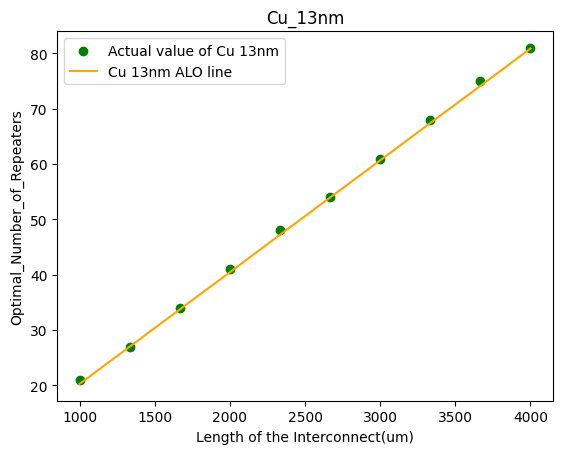

In [ ]:
length_interconnect = np.linspace(1000,4000,10)
res=[]
for length in length_interconnect:
  def Timedelay_function_Copper_13nm(x,l=length):
        R_Cu = 242.4
        L_Cu = 2.13e-12  
        C_Cu = 0.037842e-15
        R_t = (R_Cu*l)/x[1]
        C_t = (C_Cu*l)/x[1]
        R_d0 = 30.3e3
        R_T = R_d0/(x[0]*R_t)
        C_d0 = 0.22e-15
        C_l0 = 0.15e-15
        C_T = (x[0]*C_l0)/C_t
        ep = (R_t/2)*(math.sqrt(C_Cu/L_Cu))*((R_T+C_T+(R_T*C_T*(1+(C_d0/C_l0)))+0.5))/(math.sqrt(1+C_T))
        T_s = (1.48*ep + math.exp(-2.9*(ep**1.35)))*math.sqrt(((L_Cu*l)/x[1])*(C_Cu*l/x[1] +  x[0]*C_l0))
        return x[1]*T_s
  alo = ant_lion_optimizer(target_function = Timedelay_function_Copper_13nm, **parameters)
  variables = alo[:-1]
  minimum   = alo[ -1]
  res.append(np.around(variables, 4))
print(res)
length=[length_interconnect[i] for i in range(len(length_interconnect))]
optimal_repeater_size_13nm_alo_vs_length=[res[i][0] for i in range(len(res))]
optimal_repeater_number_13nm_alo_vs_length=[res[i][1] for i in range(len(res))]
#Cu_13nm
R_Cu = 242.4
L_Cu = 2.13e-12
C_Cu = 0.037842e-15
Rd = 30.3e3
C_d = 0.22e-15
Cl = 0.15e-15   
TL_R=math.sqrt(L_Cu/(R_Cu*Rd*(C_d + Cl)))
#Cu_13nm output for repeater size
repeater_size_computed_Cu_13nm_vs_length = math.sqrt((Rd*C_Cu)/(R_Cu*Cl))*(1/((1+(0.18*((TL_R)**3)))**(0.26)))
print(repeater_size_computed_Cu_13nm_vs_length)
x = (1+(0.18*((TL_R)**3)))**(0.3)
optimal_Cu_computed_13nm_vs_length = []
#Cu_13nm output for repeater number
for i in length_interconnect:
    optimal_Cu_computed_13nm_vs_length.append(math.ceil(i*(math.sqrt((R_Cu*C_Cu)/(2*Rd*(C_d + Cl)))*(1/x))))
plt.figure()
plt.title('Cu_13nm')
plt.scatter(length,optimal_Cu_computed_13nm_vs_length,color ='green',label='Actual value of Cu 13nm')
plt.plot(length,optimal_repeater_number_13nm_alo_vs_length,color = 'orange',label = 'Cu 13nm ALO line')
plt.xlabel('Length of the Interconnect(um)')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.plot()

Iteration =  0  f(x) =  1.6126357538493613e-09
Iteration =  1  f(x) =  1.490475759837317e-09
Iteration =  2  f(x) =  1.416973205434306e-09
Iteration =  3  f(x) =  1.3818288637563538e-09
Iteration =  4  f(x) =  1.3579321909635768e-09
Iteration =  5  f(x) =  1.3579321909635768e-09
Iteration =  6  f(x) =  1.3579321909635768e-09
Iteration =  7  f(x) =  1.34999641626456e-09
Iteration =  8  f(x) =  1.3495150416464492e-09
Iteration =  9  f(x) =  1.3494247787901002e-09
Iteration =  10  f(x) =  1.3493604441654928e-09
Iteration =  11  f(x) =  1.3493199673655577e-09
Iteration =  12  f(x) =  1.3493199673655577e-09
Iteration =  13  f(x) =  1.3493199673655577e-09
Iteration =  14  f(x) =  1.3493199673655577e-09
Iteration =  15  f(x) =  1.3493199673655577e-09
Iteration =  16  f(x) =  1.3493199673655577e-09
Iteration =  17  f(x) =  1.3493199673655577e-09
Iteration =  18  f(x) =  1.3493199673655577e-09
Iteration =  19  f(x) =  1.3493185485208826e-09
Iteration =  20  f(x) =  1.3493185485208826e-09
Iterat

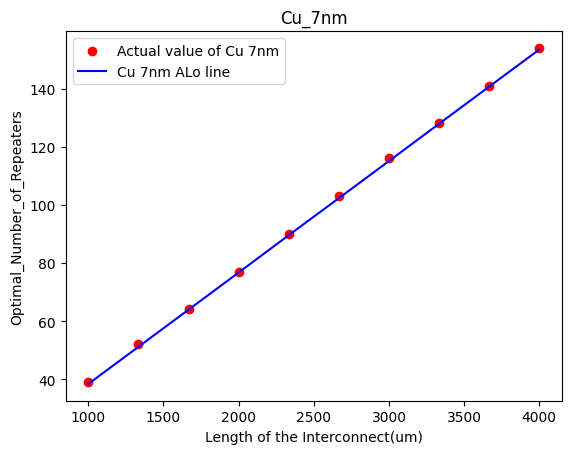

In [ ]:
res=[]
for length in length_interconnect:
  def Timedelay_function_Copper_7nm(x,l=length):
        R_Cu = 1226.7
        L_Cu = 2.24e-12
        C_Cu = 0.03177e-15
        R_t = (R_Cu*l)/x[1]
        C_t = (C_Cu*l)/x[1]
        R_d0 = 69.7e3
        R_T = R_d0/(x[0]*R_t)
        C_d0 = 0.13e-15
        C_l0 = 0.06e-15
        C_T = (x[0]*C_l0)/C_t
        ep = (R_t/2)*(math.sqrt(C_Cu/L_Cu))*((R_T+C_T+(R_T*C_T*(1+(C_d0/C_l0)))+0.5))/(math.sqrt(1+C_T))
        T_s = (1.48*ep + math.exp(-2.9*(ep**1.35)))*math.sqrt(((L_Cu*l)/x[1])*(C_Cu*l/x[1] +  x[0]*C_l0))
        return x[1]*T_s
  alo = ant_lion_optimizer(target_function = Timedelay_function_Copper_7nm, **parameters)
  variables = alo[:-1]
  minimum   = alo[ -1]
  res.append(np.around(variables, 4))
print(res)
length=[length_interconnect[i] for i in range(len(length_interconnect))]
optimal_repeater_size_7nm_alo_vs_length=[res[i][0] for i in range(len(res))]
optimal_repeater_number_7nm_alo_vs_length=[res[i][1] for i in range(len(res))]
#Cu_7nm
R_Cu = 1226.7
L_Cu = 2.24e-12
C_Cu = 0.03177e-15
Rd = 69.7e3
C_d = 0.13e-15
Cl = 0.06e-15
Cdl = C_d+Cl
TL_R=math.sqrt(L_Cu/(R_Cu*Rd*Cdl))
#Cu_7nm output for repeater size
repeater_size_computed_Cu_7nm_vs_length = math.sqrt((Rd*C_Cu)/(R_Cu*Cl))*(1/((1+(0.18*((TL_R)**3)))**(0.26)))
print(repeater_size_computed_Cu_7nm_vs_length)
x = (1+(0.18*((TL_R)**3)))**(0.3)
optimal_Cu_computed_7nm_vs_length = []
#Cu_7nm output for repeater number
for i in length_interconnect:
    optimal_Cu_computed_7nm_vs_length.append(math.ceil(i*(math.sqrt((R_Cu*C_Cu)/(2*Rd*(Cdl)))*(1/x))))
plt.figure()
plt.title('Cu_7nm')
plt.scatter(length,optimal_Cu_computed_7nm_vs_length,color ='red',label='Actual value of Cu 7nm')
plt.plot(length,optimal_repeater_number_7nm_alo_vs_length,color = 'blue',label = 'Cu 7nm ALo line')
plt.xlabel('Length of the Interconnect(um)')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()

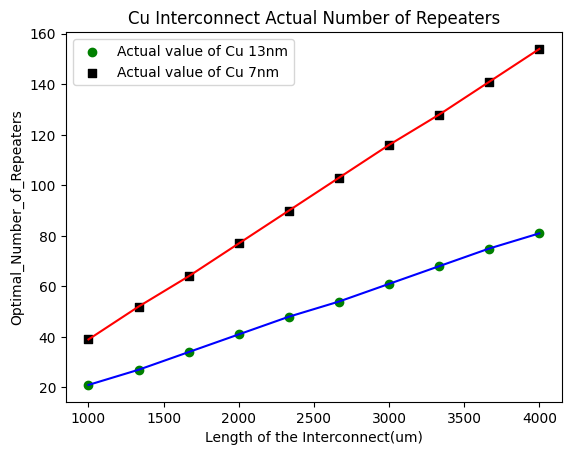

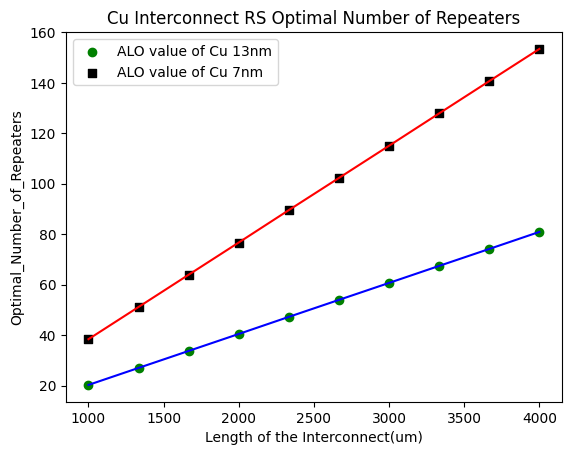

In [ ]:
plt.scatter(length,optimal_Cu_computed_13nm_vs_length,color ='green',label='Actual value of Cu 13nm')
plt.plot(length,optimal_Cu_computed_13nm_vs_length,color ='blue')
plt.scatter(length_interconnect,optimal_Cu_computed_7nm_vs_length,color ='black',label='Actual value of Cu 7nm',marker="s")
plt.plot(length_interconnect,optimal_Cu_computed_7nm_vs_length,color ='red')
plt.xlabel('Length of the Interconnect(um)')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.title('Cu Interconnect Actual Number of Repeaters')
plt.show()
plt.scatter(length,optimal_repeater_number_13nm_alo_vs_length,color ='green',label='ALO value of Cu 13nm')
plt.plot(length,optimal_repeater_number_13nm_alo_vs_length,color ='blue')
plt.scatter(length_interconnect,optimal_repeater_number_7nm_alo_vs_length,color ='black',label='ALO value of Cu 7nm',marker="s")
plt.plot(length_interconnect,optimal_repeater_number_7nm_alo_vs_length,color ='red')
plt.xlabel('Length of the Interconnect(um)')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.title('Cu Interconnect RS Optimal Number of Repeaters')
plt.show()

In [ ]:
import math
AR= 2.34
C=1.2
lambda_Cu=37.3e-9
R_g=0.4
W_Cu=13e-9
d_g=W_Cu
rho_0=2.04e-8
p=list(range(1,101))
p_Cu_list=[0.01*ele for ele in p]
z_res=[]
for p_req in p_Cu_list:
  z=(3/8)*C*(1-p_req)*((1+AR)/AR)*(lambda_Cu/W_Cu)
  z_res.append(z)
print(z_res)
alpha=((lambda_Cu*R_g)/(1-R_g))*(1.0/d_g)
y=(1/3)/((1/3)-alpha/2+alpha**2-(alpha**3)*(math.log(1+(1/alpha))))
print(alpha)
final_rho= [rho_0*(y+z_r) for z_r in z_res]
R_pul=[(final_rho[i])*1e-6/(W_Cu*W_Cu*AR) for i in range(len(final_rho))]
print(R_pul)
L_Cu = 2.13e-12
C_Cu = 0.037842e-15
R_Cu=R_pul
Rd = 30.3e3

C_d = 0.22e-15
Cl = 0.15e-15
C_d1 = C_d + Cl  
TL_R=[math.sqrt(L_Cu/(R_pul[i]*Rd*(C_d + Cl))) for i in range(len(R_pul))]
#Cu_13nm output for repeater size
repeater_size_computed_Cu_13nm_vs_p = [math.sqrt((Rd*C_Cu)/(R_pul[i]*Cl))*(1/((1+(0.18*((TL_R[i])**3)))**(0.26)))for i in range(len(TL_R))]

[1.824499704142012, 1.8060704142011832, 1.7876411242603547, 1.7692118343195264, 1.750782544378698, 1.7323532544378697, 1.7139239644970412, 1.695494674556213, 1.6770653846153847, 1.6586360946745562, 1.6402068047337275, 1.6217775147928994, 1.6033482248520707, 1.5849189349112425, 1.566489644970414, 1.5480603550295857, 1.5296310650887572, 1.511201775147929, 1.4927724852071007, 1.4743431952662722, 1.4559139053254437, 1.4374846153846155, 1.419055325443787, 1.4006260355029585, 1.38219674556213, 1.3637674556213017, 1.3453381656804733, 1.3269088757396448, 1.3084795857988165, 1.290050295857988, 1.2716210059171595, 1.253191715976331, 1.2347624260355028, 1.2163331360946743, 1.197903846153846, 1.1794745562130178, 1.1610452662721893, 1.142615976331361, 1.1241866863905323, 1.105757396449704, 1.0873281065088756, 1.0688988165680473, 1.050469526627219, 1.0320402366863906, 1.013610946745562, 0.9951816568047338, 0.9767523668639054, 0.9583230769230768, 0.9398937869822485, 0.9214644970414201, 0.903035207100

[5.225145012633847, 5.234038726719293, 5.242978009860421, 5.251963252530745, 5.26099484990415, 5.270073201927886, 5.279198713396968, 5.288371794029979, 5.297592858546339, 5.306862326745048, 5.316180623584976, 5.325548179266673, 5.334965429315802, 5.344432814668184, 5.353950781756513, 5.363519782598775, 5.373140274888416, 5.382812722086289, 5.39253759351443, 5.40231536445171, 5.412146516231395, 5.422031536340663, 5.431970918522148, 5.441965162877504, 5.452014775973115, 5.462120270947919, 5.472282167623467, 5.482500992616237, 5.492777279452252, 5.5031115686840835, 5.513504408010282, 5.523956352397291, 5.534467964203927, 5.5450398133084535, 5.555672477238364, 5.566366541302883, 5.577122598728309, 5.58794125079623, 5.598823106984696, 5.609768785112451, 5.620778911486252, 5.631854121051396, 5.642995057545516, 5.65420237365574, 5.665476731179308, 5.6768188011876966, 5.6882292641943994, 5.699708810326428, 5.711258139499624, 5.722877961597905, 5.73456899665653, 5.746331975049511, 5.75816763768

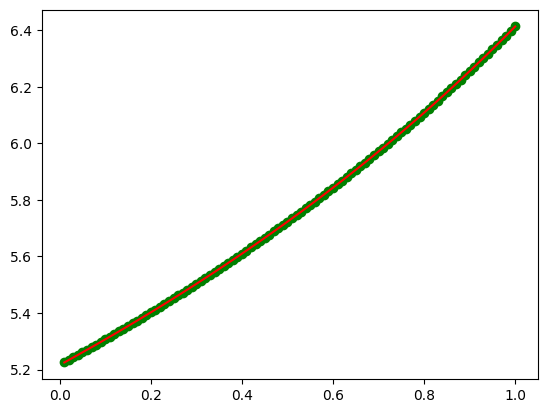

In [ ]:
import matplotlib.pyplot as plt
print(repeater_size_computed_Cu_13nm_vs_p)
plt.scatter(p_Cu_list,repeater_size_computed_Cu_13nm_vs_p,color='green')
plt.plot(p_Cu_list,repeater_size_computed_Cu_13nm_vs_p,color='red')

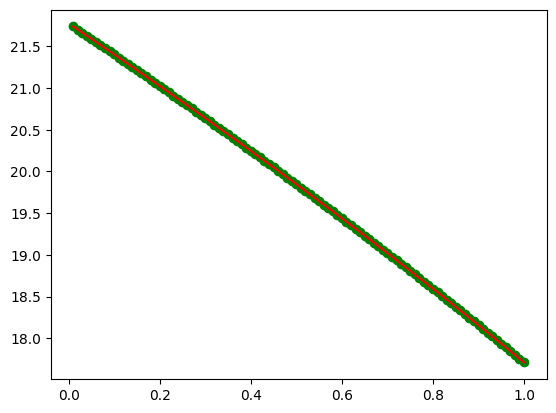

In [ ]:
optimal_Cu_computed_13nm_vs_p=[1000*(math.sqrt((R_pul[k]*C_Cu)/(2*Rd*(C_d+Cl)))*(1/(1+(0.18*((TL_R[k])**3)))**(0.3))) for k in range(len(R_pul))]
import matplotlib.pyplot as plt
plt.scatter(p_Cu_list,optimal_Cu_computed_13nm_vs_p,color='green')
plt.plot(p_Cu_list,optimal_Cu_computed_13nm_vs_p,color='red')

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
# ALO - Parameters
parameters = {
    'colony_size': 50,
    'min_values': (1, 1),
    'max_values': (100, 200),
    'iterations': 50,
    'verbose': True
}
res=[]
for p in p_Cu_list:
  def Timedelay_function_Copper_13nm_p_req(x,p_req=p):
        l=1000
        lambda_Cu=37.3e-9
        R_g=0.4
        W_Cu=13e-9
        d_g=W_Cu
        AR=2.34
        C=1.2
        rho_0=2.04e-8
        # p_req=1.0
        L_Cu = 2.13e-12  
        C_Cu = 0.037842e-15
        # p_req=p_req
        alpha=((lambda_Cu*R_g)/((1-R_g)*(d_g)))
        y=(1/3)/((1/3)-alpha/2+alpha**2-(alpha**3)*(math.log(1+(1/alpha))))
        z=(3/8)*C*(1-p_req)*((1+AR)/AR)*(lambda_Cu/W_Cu)
        res_list = rho_0*(y+z)
        R_pul=(res_list)*1e-6/(W_Cu*W_Cu*AR)
        R_Cu=R_pul
        print(R_Cu)
        R_t = (R_Cu*l)/x[1]
        C_t = (C_Cu*l)/x[1]
        R_d0 = 30.3e3
        R_T = R_d0/(x[0]*R_t)
        C_d0 = 0.22e-15
        C_l0 = 0.15e-15
        C_T = (x[0]*C_l0)/C_t
        TL_R=math.sqrt(L_Cu/(R_pul*Rd*(C_d + Cl)))
        x[0]=math.sqrt((Rd*C_Cu)/(R_pul*Cl))*(1/((1+(0.18*((TL_R)**3)))**(0.26)))
        x[1]=(1000*(math.sqrt((R_pul*C_Cu)/(2*Rd*(C_d0+C_l0)))*(1/(1+(0.18*((TL_R)**3)))**(0.3))))
        ep = (R_t/2)*(math.sqrt(C_Cu/L_Cu))*((R_T+C_T+(R_T*C_T*(1+(C_d0/C_l0)))+0.5))/(math.sqrt(1+C_T))
        T_s = (1.48*ep + math.exp(-2.9*(ep**1.35)))*math.sqrt(((L_Cu*l)/x[1])*(C_Cu*l/x[1] +  x[0]*C_l0))
        return x[1]*T_s
  alo = ant_lion_optimizer(target_function = Timedelay_function_Copper_13nm_p_req, **parameters)
  variables = alo[:-1]
  minimum   = alo[ -1]
  res.append(np.around(variables, 4))
  print(res)

Streaming output truncated to the last 5000 lines.
186.81362530805112
186.81362530805112
Iteration =  6  f(x) =  5.004919101399273e-10
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.813625

In [ ]:
optimal_repeater_size_13nm_pso_vs_p=[res[i][0] for i in range(len(res))]
optimal_repeater_number_13nm_pso_vs_p=[res[i][1] for i in range(len(res))]

#Calculation for 7nm

In [ ]:
lambda_Cu=37.3e-9
import numpy as np
R_g=0.4

In [ ]:
W_Cu=7e-9
d_g=W_Cu
alpha=((lambda_Cu*R_g)/(1-R_g))*(1.0/d_g)
#alpha=(lambda_Cu* R_g)/(d_g*(1-R_g))
print(alpha)
import math

3.5523809523809526


In [ ]:
AR=2.4
C=1.2
p_Cu=0.41
rho_0=2.04e-8

In [ ]:
alpha
y=(1/3)/((1/3)-alpha/2+alpha**2-(alpha**3)*(math.log(1+(1/alpha))))

In [ ]:
p=list(range(1,101))
p_Cu_list=[0.01*ele for ele in p]
z_res=[]
for p_req in p_Cu_list:
  z=(3/8)*C*(1-p_req)*((1+AR)/AR)*(lambda_Cu/W_Cu)
  z_res.append(z)
print(z_res)

[3.362994642857143, 3.329025, 3.295055357142857, 3.2610857142857146, 3.2271160714285716, 3.1931464285714286, 3.1591767857142856, 3.1252071428571435, 3.0912375000000005, 3.0572678571428575, 3.0232982142857145, 2.9893285714285716, 2.9553589285714286, 2.921389285714286, 2.887419642857143, 2.85345, 2.819480357142857, 2.785510714285715, 2.751541071428572, 2.717571428571429, 2.683601785714286, 2.649632142857143, 2.6156625000000004, 2.5816928571428575, 2.5477232142857145, 2.5137535714285715, 2.479783928571429, 2.445814285714286, 2.411844642857143, 2.377875, 2.3439053571428574, 2.3099357142857144, 2.2759660714285714, 2.2419964285714284, 2.2080267857142855, 2.174057142857143, 2.1400875000000004, 2.1061178571428574, 2.0721482142857144, 2.0381785714285714, 2.004208928571429, 1.970239285714286, 1.936269642857143, 1.9023000000000003, 1.8683303571428576, 1.8343607142857146, 1.8003910714285716, 1.7664214285714288, 1.7324517857142858, 1.6984821428571428, 1.6645125, 1.6305428571428573, 1.59657321428571

In [ ]:
final_rho= [rho_0*(y+z_r) for z_r in z_res]

In [ ]:
R_pul=[(final_rho[i])*1e-6/(W_Cu*W_Cu*AR) for i in range(len(final_rho))]
print(R_pul)
R_Cu = 1352.7
L_Cu = 2.24e-12
C_Cu = 0.03177e-15
Rd = 69.7e3
C_d = 0.13e-15
Cl = 0.06e-15

[1588.5708952167327, 1582.6782020680444, 1576.7855089193563, 1570.8928157706682, 1565.0001226219804, 1559.1074294732923, 1553.214736324604, 1547.3220431759164, 1541.429350027228, 1535.53665687854, 1529.643963729852, 1523.7512705811637, 1517.8585774324758, 1511.9658842837878, 1506.0731911351, 1500.1804979864116, 1494.2878048377236, 1488.3951116890357, 1482.5024185403474, 1476.6097253916594, 1470.7170322429715, 1464.8243390942835, 1458.9316459455956, 1453.0389527969073, 1447.146259648219, 1441.2535664995312, 1435.3608733508431, 1429.4681802021553, 1423.5754870534668, 1417.682793904779, 1411.790100756091, 1405.897407607403, 1400.004714458715, 1394.1120213100264, 1388.2193281613386, 1382.3266350126507, 1376.4339418639627, 1370.5412487152748, 1364.6485555665868, 1358.7558624178985, 1352.8631692692106, 1346.9704761205223, 1341.0777829718345, 1335.1850898231467, 1329.2923966744584, 1323.3997035257705, 1317.5070103770822, 1311.6143172283942, 1305.721624079706, 1299.828930931018, 1293.936237782

In [ ]:
TL_R=[math.sqrt(L_Cu/(R_pul[i]*Rd*(C_d + Cl))) for i in range(len(R_pul))]
#Cu_7nm output for repeater size
repeater_size_computed_Cu_7nm_vs_p = [math.sqrt((Rd*C_Cu)/(R_pul[i]*Cl))*(1/((1+(0.18*((TL_R[i])**3)))**(0.26)))for i in range(len(TL_R))]

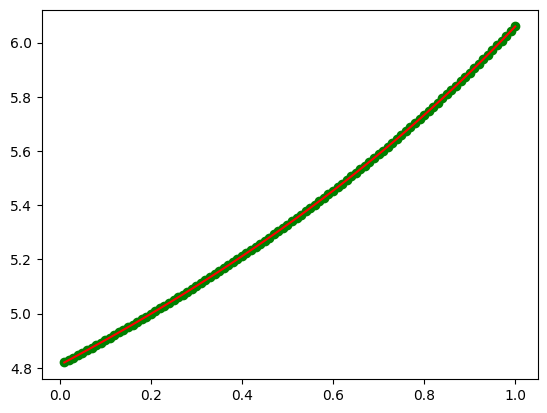

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(p_Cu_list,repeater_size_computed_Cu_7nm_vs_p,color='green')
plt.plot(p_Cu_list,repeater_size_computed_Cu_7nm_vs_p,color='red')

In [ ]:
optimal_Cu_computed_7nm_vs_p=[1000*(math.sqrt((R_pul[k]*C_Cu)/(2*Rd*(C_d+Cl)))*(1/(1+(0.18*((TL_R[k])**3)))**(0.3))) for k in range(len(R_pul))]

In [ ]:
optimal_Cu_computed_7nm_vs_p

[43.65195461544911,
 43.57091743732349,
 43.489729257705626,
 43.40838922932567,
 43.32689649696059,
 43.245250197329355,
 43.16344945898609,
 43.081493402211706,
 42.999381138903416,
 42.9171117724625,
 42.83468439768005,
 42.752098100620806,
 42.66935195850492,
 42.58644503958758,
 42.503376403036754,
 42.42014509880843,
 42.336750167520044,
 42.253190640321336,
 42.169465538763,
 42.085573874663154,
 42.00151464997112,
 41.917286856628934,
 41.83288947643036,
 41.74832148087719,
 41.66358183103307,
 41.57866947737458,
 41.49358335963956,
 41.40832240667261,
 41.322885536267854,
 41.23727165500862,
 41.151479658104115,
 41.06550842922322,
 40.9793568403249,
 40.89302375148555,
 40.80650801072307,
 40.719808453817436,
 40.632923904127985,
 40.54585317240703,
 40.458595056609994,
 40.37114834170182,
 40.28351179945948,
 40.1956841882708,
 40.10766425292915,
 40.019450724424175,
 39.93104231972833,
 39.842437741579175,
 39.75363567825723,
 39.66463480335947,
 39.5754337755681,
 39.48603

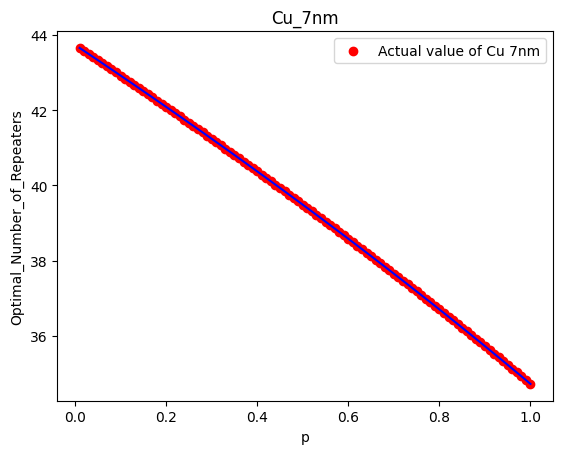

In [ ]:
plt.figure()
#plt.subplot(2,2,1)
plt.title('Cu_7nm')
plt.scatter(p_Cu_list,optimal_Cu_computed_7nm_vs_p,color ='red',label='Actual value of Cu 7nm')
plt.plot(p_Cu_list,optimal_Cu_computed_7nm_vs_p,color ='blue')
#plt.plot(length_interconnect,Opt_Rep_Number_Cu_7nm,color = 'blue',label = 'Cu 7nm PSO line')
plt.xlabel('p')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.show()

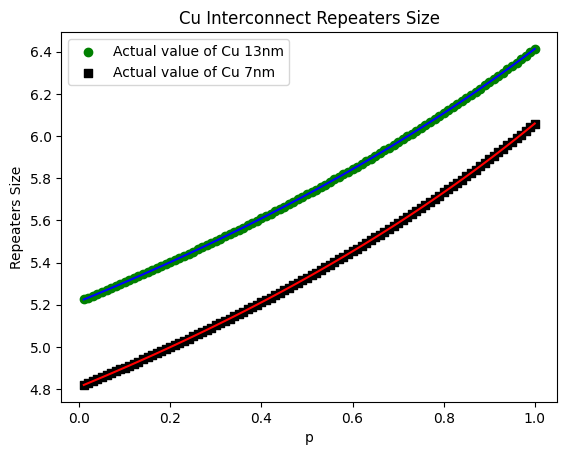

In [ ]:
plt.scatter(p_Cu_list,repeater_size_computed_Cu_13nm_vs_p,color ='green',label='Actual value of Cu 13nm')
plt.plot(p_Cu_list,repeater_size_computed_Cu_13nm_vs_p,color ='blue')
plt.scatter(p_Cu_list,repeater_size_computed_Cu_7nm_vs_p,color ='black',label='Actual value of Cu 7nm',marker="s")
plt.plot(p_Cu_list,repeater_size_computed_Cu_7nm_vs_p,color ='red')
plt.xlabel('p')
plt.ylabel('Repeaters Size')
plt.legend()
plt.title('Cu Interconnect Repeaters Size')
plt.show()

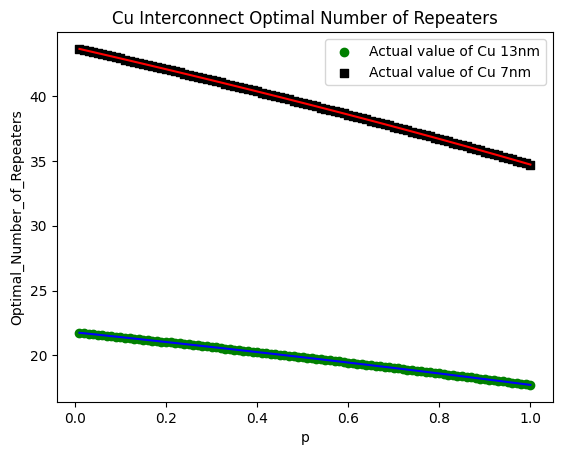

In [ ]:
plt.scatter(p_Cu_list,optimal_Cu_computed_13nm_vs_p,color ='green',label='Actual value of Cu 13nm')
plt.plot(p_Cu_list,optimal_Cu_computed_13nm_vs_p,color ='blue')
plt.scatter(p_Cu_list,optimal_Cu_computed_7nm_vs_p,color ='black',label='Actual value of Cu 7nm',marker="s")
plt.plot(p_Cu_list,optimal_Cu_computed_7nm_vs_p,color ='red')
plt.xlabel('p')
plt.ylabel('Optimal_Number_of_Repeaters')
plt.legend()
plt.title('Cu Interconnect Optimal Number of Repeaters')
plt.show()